# Dividing the data into epochs with mne

In [50]:
import os
import mne
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from mne_bids import read_raw_bids, BIDSPath

class BIDSEEGDataset(Dataset):
    def __init__(self, bids_root, patients_tsv, binary=False):
        self.bids_root = bids_root
        self.binary = binary

        # use only these channels for classification
        self.selected_channels = ['F3','F4','C3','C4','O1','O2','A1','A2']

        # read the patients.tsv file
        self.patients_df = pd.read_csv(patients_tsv, delimiter='\t')

        # create a dictionary with patient_id as key and pathology as value
        self.pathology_dict = dict(zip(self.patients_df['participant_id'], self.patients_df['pathology']))

        # get all the subjects in the bids_root
        self.subjects = [d for d in os.listdir(bids_root) if d.startswith('sub-')] # ['sub-03'] #
        self.all_epochs = []
        self.all_labels = []

        for subject in self.subjects:
            subject_id = subject.replace('sub-', '')
            subject_folder = os.path.join(self.bids_root, subject)
            sessions = [d for d in os.listdir(subject_folder) if d.startswith('ses-')]

            for session in sessions:
                session_id = session.replace('ses-', '')
                bids_path = BIDSPath(subject=subject_id, session=session_id, task='verbalWM',
                                              run='01', datatype='eeg', root=self.bids_root)
                try:
                    raw = read_raw_bids(bids_path, verbose=False)
                except:
                    continue

                raw.load_data(verbose=False)
                
                raw.filter(l_freq=1, h_freq=None, verbose=False, fir_design='firwin', skip_by_annotation='edge')
                raw.pick(picks=self.selected_channels, verbose=False)
                raw.resample(sfreq=250)  # Resample to 250 Hz


                events, _ = mne.events_from_annotations(raw, verbose=False)
                epochs = mne.Epochs(raw, events, verbose=False, tmax=8)
                pathology_label = self.pathology_dict.get(f'sub-{subject_id}', 'Unknown')
                for epoch_data in epochs.get_data():
                    self.all_epochs.append(epoch_data)
                    if binary:
                        if pathology_label == 'hippocampal sclerosis':
                            self.all_labels.append('hippocampal sclerosis')
                        else:
                            self.all_labels.append('other')
                    else:
                        self.all_labels.append(pathology_label)

        # save the labels in a dictionary to convert them to numbers
        # and to easily use them in the dataloader
        if not binary:
            self.labels = {}
            for i, pathology in enumerate(set(self.all_labels)):
                self.labels[pathology] = i
        else:
            self.labels = {
                'hippocampal sclerosis': 0,
                'other': 1
            }




    def __len__(self):
        return len(self.all_epochs)

    def __getitem__(self, idx):
        epoch_data = self.all_epochs[idx]
        pathology_label = self.all_labels[idx]
        # create one hot encoding for the pathology
        if self.binary:
            if pathology_label == 'hippocampal sclerosis':
                label = torch.tensor(0)
            else:
                label = torch.tensor(1)
        else: 
            label = torch.tensor(self.labels[pathology_label])

        return torch.tensor(epoch_data, dtype=torch.float32), label

In [42]:
from torch.nn.utils.rnn import pad_sequence

# Initialize the custom dataset
bids_root = 'data'
patients_tsv = 'data/participants.tsv'
dataset = BIDSEEGDataset(bids_root, patients_tsv, binary=False)
dataset_binary = BIDSEEGDataset(bids_root, patients_tsv, binary=True)

# dataset stats
print(f'Total number of samples: {len(dataset)}')

# print number of different pathology labels


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Invalid date encountered (2023-09-13 14:23:60).
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 43 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 34 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 47 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 46 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 47 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Invalid date encountered (2023-09-13 14:23:60).
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 43 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 34 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 47 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 46 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 47 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Total number of samples: 3217


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_5590/1559471638.py:37: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


In [43]:
# Create test, validation and train splits
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Split the dataset into training and a temporary set (70% train, 30% temp)
# we need this to not loose the `all_labels` list
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    random_state=42,
    stratify=dataset.all_labels,
    shuffle=True
)

train_indices_binary, temp_indices_binary = train_test_split(
    list(range(len(dataset_binary))),
    test_size=0.3,
    random_state=42,
    stratify=dataset_binary.all_labels,
    shuffle=True
)

# Split the temporary set into validation and test sets (50% validation, 50% test of the temp set)
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    random_state=42,
    stratify=[dataset.all_labels[i] for i in temp_indices],
    shuffle=True
)

val_indices_binary, test_indices_binary = train_test_split(
    temp_indices_binary,
    test_size=0.5,
    random_state=42,
    stratify=[dataset_binary.all_labels[i] for i in temp_indices_binary],
    shuffle=True
)

# Create Subset instances using the split indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_dataset_binary = Subset(dataset_binary, train_indices_binary)
val_dataset_binary = Subset(dataset_binary, val_indices_binary)
test_dataset_binary = Subset(dataset_binary, test_indices_binary)


In [44]:
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create a data loader for the binary dataset
train_loader_binary = DataLoader(train_dataset_binary, batch_size=batch_size, shuffle=True)
val_loader_binary = DataLoader(val_dataset_binary, batch_size=batch_size, shuffle=False)
test_loader_binary = DataLoader(test_dataset_binary, batch_size=batch_size, shuffle=False)

In [45]:
from torch import nn
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, Chans=8, Samples=2051, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout', outputs=2):
        super(EEGNet, self).__init__()
        
        # First Convolutional Block
        self.block1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding=(0, kernLength // 2), bias=False),
            nn.BatchNorm2d(F1),
            nn.ReLU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )
        
        # Depthwise Convolution
        self.depthwise = nn.Conv2d(F1, F1*D, (Chans, 1), groups=F1, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(F1*D)
        self.depthwise_activation = nn.ReLU()
        
        # Separable Convolution
        self.pointwise = nn.Conv2d(F1*D, F2, (1, 1), bias=False)
        self.pointwise_bn = nn.BatchNorm2d(F2)
        self.pointwise_activation = nn.ReLU()
        self.pointwise_pooling = nn.AvgPool2d((1, 8))
        self.pointwise_dropout = nn.Dropout(dropoutRate)
        
        # Classification Layer
        self.classify = nn.Linear(F2, outputs)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.block1(x)
        
        # Depthwise Convolution
        x = self.depthwise(x)
        x = self.depthwise_bn(x)
        x = self.depthwise_activation(x)
        
        # Separable Convolution
        x = self.pointwise(x)
        x = self.pointwise_bn(x)
        x = self.pointwise_activation(x)
        x = self.pointwise_pooling(x)
        x = self.pointwise_dropout(x)
        
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        x = self.classify(x)
        x = F.log_softmax(x, dim=1)
        return x

In [51]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
learning_rate = 0.001
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Initialize the model, criterion, and optimizer
model = EEGNet(outputs=len(dataset.labels)).to(device)
model_binary = EEGNet(outputs=2).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer_binary = optim.Adam(model_binary.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion_binary = nn.CrossEntropyLoss()

best_val_accuracy = 0.0  # To keep track of the best validation accuracy
best_val_accuracy_binary = 0.0  # To keep track of the best validation accuracy

# Lists to store metrics for plotting
train_losses = []
train_losses_binary = []
val_losses = []
val_losses_binary = []
train_accuracies = []
train_accuracies_binary = []
val_accuracies = []
val_accuracies_binary = []

# Training loop
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    model.train()  # Set the model to training mode
    model_binary.train()  # Set the model to training mode
    total_loss = 0.0
    total_loss_binary = 0.0
    correct = 0
    correct_binary = 0
    total = 0
    total_binary = 0
    
    # Training Phase
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        outputs_binary = model_binary(data)

        loss = criterion(outputs, labels)
        loss_binary = criterion_binary(outputs_binary, labels)
        
        # Backward pass and optimize
        loss.backward()
        loss_binary.backward()
        optimizer.step()
        optimizer_binary.step()
        
        total_loss += loss.item()
        total_loss_binary += loss_binary.item()
        _, predicted = outputs.max(1)
        _, predicted_binary = outputs_binary.max(1)
        total += labels.size(0)
        total_binary += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        correct_binary += predicted_binary.eq(labels).sum().item()

    train_accuracy = 100.*correct/total
    train_accuracy_binary = 100.*correct_binary/total_binary

    train_losses.append(total_loss/len(train_loader))
    train_losses_binary.append(total_loss_binary/len(train_loader))
    train_accuracies.append(train_accuracy)
    train_accuracies_binary.append(train_accuracy_binary)
    
    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    model_binary.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_correct_binary = 0
    val_total = 0
    val_total_binary = 0
    val_loss = 0.0
    val_loss_binary = 0.0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            outputs_binary = model_binary(data)
            loss = criterion(outputs, labels)
            loss_binary = criterion_binary(outputs_binary, labels)
            _, predicted = outputs.max(1)
            _, predicted_binary = outputs_binary.max(1)
            val_total += labels.size(0)
            val_total_binary += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            val_correct_binary += predicted_binary.eq(labels).sum().item()
            val_loss += loss.item()
            val_loss_binary += loss_binary.item()
    
    val_accuracy = 100. * val_correct / val_total
    val_accuracy_binary = 100. * val_correct_binary / val_total_binary
    val_losses.append(val_loss/len(val_loader))
    val_losses_binary.append(val_loss_binary/len(val_loader))
    val_accuracies.append(val_accuracy)
    val_accuracies_binary.append(val_accuracy_binary)
    
    # pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss_binary/len(train_loader):.4f}, Training Accuracy: {train_accuracy_binary:.2f}%, Validation Loss: {val_loss_binary/len(val_loader):.4f}, Validation Accuracy: {val_accuracy_binary:.2f}%")
    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
    if val_accuracy_binary > best_val_accuracy_binary:
        best_val_accuracy_binary = val_accuracy_binary
        torch.save(model_binary.state_dict(), 'best_model_binary.pth')

# Final test on the test dataset
model.eval()  # Set the model to evaluation mode
model_binary.eval()  # Set the model to evaluation mode
test_correct = 0
test_correct_binary = 0
test_total = 0
test_total_binary = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        outputs_binary = model_binary(data)
        _, predicted = outputs.max(1)
        _, predicted_binary = outputs_binary.max(1)
        test_total += labels.size(0)
        test_total_binary += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        test_correct_binary += predicted_binary.eq(labels).sum().item()

test_accuracy = 100. * test_correct / test_total
test_accuracy_binary = 100. * test_correct_binary / test_total_binary
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Accuracy Binary: {test_accuracy_binary:.2f}%")



Epoch [10/100], Training Loss: 0.1570, Training Accuracy: 43.68%, Validation Loss: 0.1244, Validation Accuracy: 43.79%:  10%|█         | 10/100 [00:18<02:47,  1.86s/it]


KeyboardInterrupt: 

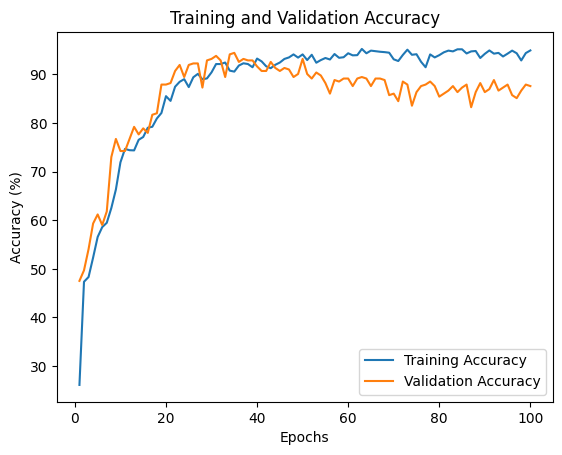

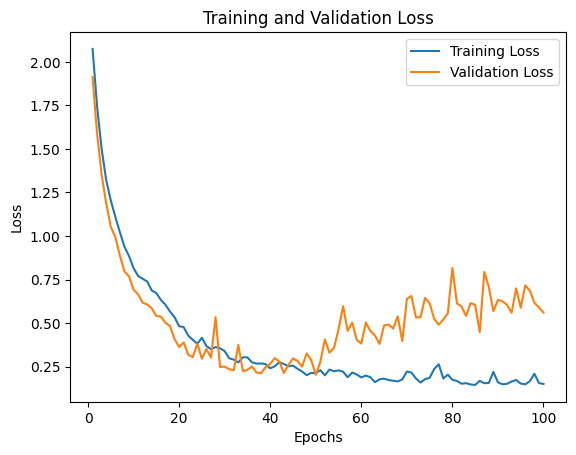

In [48]:
from matplotlib import pyplot as plt

# Plotting
epochs = range(1, num_epochs + 1)

# Plot training and validation accuracy
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()